In [1]:
import zipfile
with zipfile.ZipFile("EuroSAT.zip","r") as zip_ref:
    zip_ref.extractall()

In [1]:
import torch
import pandas as pd
import numpy as np
import sys, time

import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True #to make reproducible result

cuda:0


In [3]:
DIR = '2750'

# 1. ETL

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
data = datasets.ImageFolder(DIR, transform=transform)
data

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: 2750
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# 2. EDA

In [6]:
classNames = list(data.class_to_idx)

In [7]:
def displayImage(img):
    img = img / 2 + 0.5 # denormalize image
    plt.imshow(transforms.ToPILImage()(img))

torch.Size([3, 64, 64])


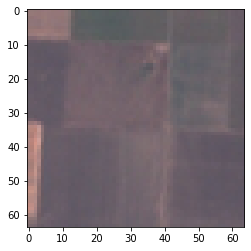

In [8]:
for temp in data:
    print(temp[0].shape)
    image = temp[0]
    displayImage(temp[0])
    break

In [9]:
def show_sample_images(dataset):
    loader = DataLoader(dataset, batch_size = 10, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = make_grid(images, nrow = 5)
    grid = grid / 2 + 0.5 # denormalize image
    im_transpose = np.transpose(grid, (1, 2, 0)) 
    plt.figure(figsize=(11, 11))
    plt.imshow(im_transpose)
    print('Encoded Labels: ', labels)
    print('Labels:')
    for label in labels:
        print(classNames[label])

Encoded Labels:  tensor([7, 9, 8, 2, 1, 7, 9, 1, 0, 0])
Labels:
Residential
SeaLake
River
HerbaceousVegetation
Forest
Residential
SeaLake
Forest
AnnualCrop
AnnualCrop


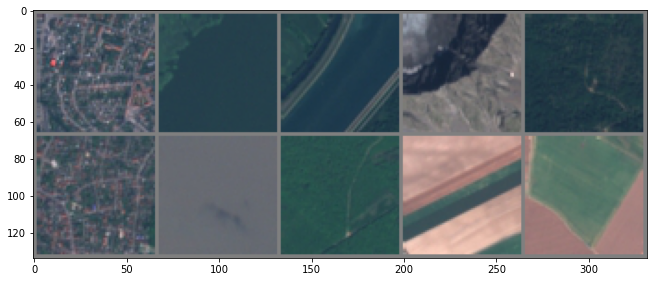

In [10]:
show_sample_images(data)

In [11]:
# getting labels/targets
classNames = list(data.class_to_idx)
classNames

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

## Checking if dataset is balanced

In [12]:
# counting no. of each label
labels, noOfImagesPerClass = torch.unique(torch.tensor(data.targets), return_counts=True)

In [13]:
classCount =  pd.DataFrame({'class': labels, 'count': noOfImagesPerClass})

In [14]:
classCount

,class,count
0,0,3000
1,1,3000
2,2,3000
3,3,2500
4,4,2500
5,5,2000
6,6,2500
7,7,3000
8,8,2500
9,9,3000


In [15]:
for index, i in enumerate(range(len(noOfImagesPerClass))):
    print(f"{index} {classNames[i]}: {noOfImagesPerClass[i]}")

0 AnnualCrop: 3000
1 Forest: 3000
2 HerbaceousVegetation: 3000
3 Highway: 2500
4 Industrial: 2500
5 Pasture: 2000
6 PermanentCrop: 2500
7 Residential: 3000
8 River: 2500
9 SeaLake: 3000


<AxesSubplot:xlabel='class', ylabel='count'>

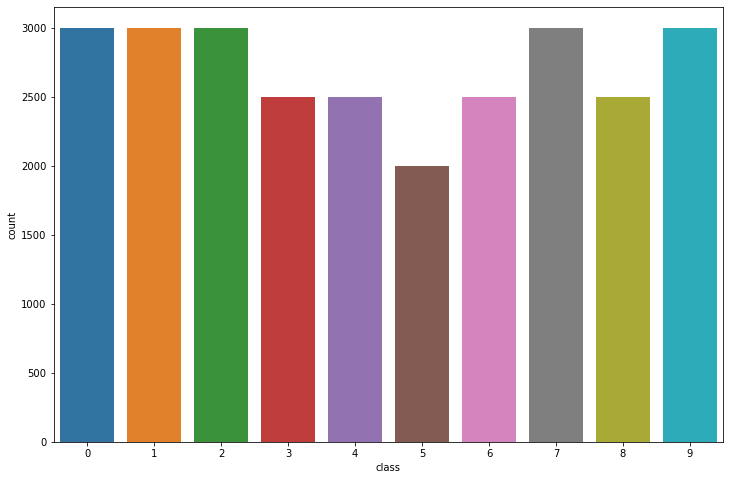

In [16]:
plt.figure(figsize=(12, 8))
sns.barplot(x = 'class', y='count', data = classCount)

In [17]:
len(data)

27000

In [18]:
train_set, test_set = torch.utils.data.random_split(data, [21600, 5400])  # test set 20 percent
train_set, val_set = torch.utils.data.random_split(train_set, [17280, 4320]) # valid set 20 percent

In [19]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
# val_loader = DataLoader(val_set, len(val_set), shuffle=True)
# test_loader = DataLoader(test_set, len(test_set), shuffle=True)
val_loader = DataLoader(val_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)

# 3. Create Model

## Model 1: Base CNN Model

In [20]:
class EuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 128, 3, 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.linear = nn.Linear(128*31*31, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
        # self.relu    = nn.ReLU()
    
    def forward(self, image):
        out = self.conv(image) 
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 128*31*31)
        out = self.dropoutLayer(out)
        out = self.linear(out)
        return out

## Model 2: Deeper CNN Model

In [21]:
class deepEuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 128, 3, 1, 0)
        self.batchNorm1 = nn.BatchNorm2d(num_features=128)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(128, 256, 3, 1, 0)
        self.batchNorm2 = nn.BatchNorm2d(num_features=256)
        
        self.linear1 = nn.Linear(256*14*14, 100)
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
    
    def forward(self, image):
        out = self.conv1(image) 
        out = self.relu(out)
        out = self.batchNorm1(out)
        out = self.maxpool(out)
        
        out = self.conv2(out) 
        out = self.relu(out)
        out = self.batchNorm2(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 256*14*14)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear3(out)
        return out

In [22]:
## Model 3: More Deeper CNN Model

In [23]:
class deeperEuroCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 0)
        self.batchNorm1 = nn.BatchNorm2d(num_features=64)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 0)
        self.batchNorm2 = nn.BatchNorm2d(num_features=128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 0)
        self.batchNorm3 = nn.BatchNorm2d(num_features=256)
        
        
        self.linear1 = nn.Linear(256*6*6, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 75)
        self.linear4 = nn.Linear(75, 10)
        self.relu    = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p=0.2)
    
    def forward(self, image):
        out = self.conv1(image) 
        out = self.relu(out)
        out = self.batchNorm1(out)
        out = self.maxpool(out)
        
        out = self.conv2(out) 
        out = self.relu(out)
        out = self.batchNorm2(out)
        out = self.maxpool(out)
        
        out = self.conv3(out) 
        out = self.relu(out)
        out = self.batchNorm3(out)
        out = self.maxpool(out)
        
        out = out.reshape(-1, 256*6*6)
        out = self.dropoutLayer(out)
        
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear3(out)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        
        out = self.linear4(out)
        return out

# 4. Train Model

## Train Model 1

In [24]:
baseModel = EuroCNN().to(device)

In [25]:
print(baseModel)

EuroCNN(
  (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=123008, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(baseModel)

  3456
   128
1230080
    10
______
1233674


## Test Model

In [28]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = baseModel(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [29]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseModel.parameters(), lr=0.001)

## Train Model

In [30]:
class EarlyStopping():
    def __init__(self, patience, threshold):
        self.patience      = 5
        self.threshold     = 0.1
        self.prev_val_loss = None
        self.patienceCount = 0
        
    def _checkPatience(self,):
        if self.patienceCount == self.patience:
            return True
        else:
            self.patienceCount += 1
            return False
    
    def checkCondition(self, val_loss):
        if self.prev_val_loss == None:
            self.prev_val_loss = val_loss
        elif val_loss - self.prev_val_loss > self.threshold:
            return self._checkPatience()
        
        self.patienceCount = 0
        return False

In [31]:
def train(model, optimizer, J_fn, filepath, epochs=10, patience = 5, threshold = 0.1):
    
    earlyStopping = EarlyStopping(patience, threshold)
    
    val_old_loss = float("Inf")
    train_losses = []
    train_accs   = []
    avg_train_losses_per_epoch = []
    avg_train_accs_per_epoch   = []
    val_losses   = []
    val_accs     = []
    training_time = []
    training_time_per_epoch = []
    
    for e in range(epochs):
        total_corr       = 0
        total_loss       = 0
        total_train_loss = 0
        total_time_epoch = 0
        for b, (image, label) in enumerate(train_loader):
            start_time = time.time()

            image = image.to(device)
            label = label.to(device)

            yhat = model(image)
            train_loss = J_fn(yhat, label)
            total_train_loss += train_loss

            train_losses.append(train_loss)
            predicted = torch.max(yhat, 1)[1]
            batch_corr = (predicted == label).sum()
            total_corr += batch_corr

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_acc = (total_corr * 100) / (batch_size * (b + 1))
            train_accs.append(train_acc)

            total_time = time.time() - start_time
            total_time_epoch += total_time
            training_time.append(total_time)

            if (b+1) % 64 == 0:
                print(f"Epoch: {e + 1} - Batch: {b + 1} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc:.2f} - Total Time: {total_time:.2f}s")
                # print("Loss Gradient for first Conv Layer: ", torch.mean(model.conv1.weight.grad) )
        
        avg_train_time = total_time_epoch / len(train_loader)
        training_time_per_epoch.append(avg_train_time)
        
        avg_train_loss = total_train_loss / len(train_loader)   
        avg_train_acc  = (total_corr * 100) / len(train_set)
        
        avg_train_losses_per_epoch.append(avg_train_loss)
        avg_train_accs_per_epoch.append(avg_train_acc)
        
        print(f"++++++End of Epoch {e + 1} ++++++ Avg Train Loss: {avg_train_loss:.2f} - Avg Train Acc: {avg_train_acc:.2f} - Avg Train Time: {avg_train_time:.2f}")

        with torch.no_grad():
            val_corr       = 0 
            total_val_loss = 0
            for val_image, val_label in val_loader:
                val_image = val_image.to(device)
                val_label = val_label.to(device)
                val_yhat = model(val_image)
                val_loss = J_fn(val_yhat, val_label)
                total_val_loss += val_loss
                val_predicted = torch.max(val_yhat, 1)[1]
                val_corr += (val_predicted == val_label).sum()
            val_acc = (val_corr * 100) / len(val_set)
            avg_val_loss = total_val_loss / len(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            if avg_val_loss < val_old_loss:
                val_old_loss = avg_val_loss
                saveObject = {
                    'epoch': e + 1,
                    'batch': b + 1,
                    'train_loss': avg_train_loss,
                    'train_acc': avg_train_acc,
                    'val_loss': avg_val_loss,
                    'val_acc': val_acc,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }
                torch.save(saveObject, filepath)
            
        if earlyStopping.checkCondition(avg_val_loss):
            break
            
        print(f"++++++Validation++++++ Val Loss: {avg_val_loss:.2f} - Val Acc: {val_acc:.2f}")
        
        
    return train_losses, avg_train_losses_per_epoch, train_accs, avg_train_accs_per_epoch, training_time, training_time_per_epoch, val_losses, val_accs

In [32]:
filepath = 'bestmodel1.pt'

In [33]:
train_losses, avg_train_losses_per_epoch, train_accs, avg_train_accs_per_epoch, training_time, training_time_per_epoch, val_losses, val_accs = train(baseModel, optimizer, J_fn, filepath, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.30 - Train Acc: 40.97 - Total Time: 0.01s
Epoch: 1 - Batch: 128 - Train Loss: 0.84 - Train Acc: 51.01 - Total Time: 0.01s
Epoch: 1 - Batch: 192 - Train Loss: 0.88 - Train Acc: 55.31 - Total Time: 0.01s
Epoch: 1 - Batch: 256 - Train Loss: 0.64 - Train Acc: 58.26 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.52 - Avg Train Acc: 58.74 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.86 - Val Acc: 72.13
Epoch: 2 - Batch: 64 - Train Loss: 0.79 - Train Acc: 74.66 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 0.92 - Train Acc: 74.57 - Total Time: 0.00s
Epoch: 2 - Batch: 192 - Train Loss: 0.77 - Train Acc: 75.50 - Total Time: 0.00s
Epoch: 2 - Batch: 256 - Train Loss: 0.73 - Train Acc: 75.45 - Total Time: 0.00s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.73 - Avg Train Acc: 75.39 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.71 - Val Acc: 77.15
Epoch: 3 - Batch: 64 - Train Loss: 0.39 - Train Acc: 83.23 - T

## Plotting loss

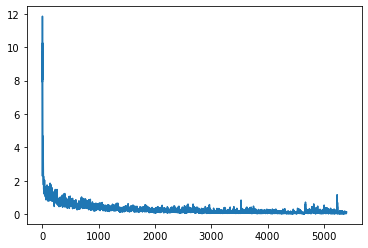

In [34]:
plt.plot(torch.Tensor(train_losses).cpu())

In [35]:
def plotLoss(trainingLoss, valLoss):
    plt.plot(trainingLoss)
    plt.plot(valLoss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Val Loss"])

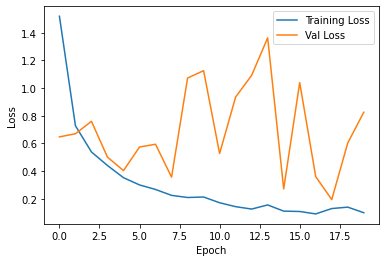

In [36]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch).cpu(), torch.Tensor(val_losses).cpu())

## Plotting accuracy

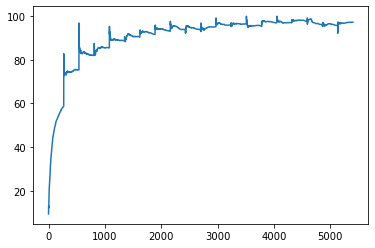

In [37]:
plt.plot(torch.Tensor(train_accs).cpu())

In [38]:
def plotAccuracy(trainingAcc, valAcc):
    plt.plot(trainingAcc)
    plt.plot(valAcc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(["Training Accuracy", "Val Accuracy"])

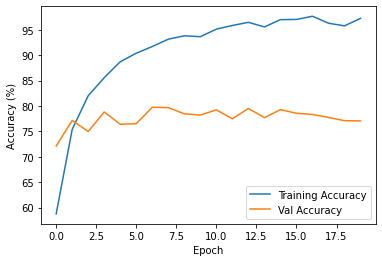

In [39]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch).cpu(), torch.Tensor(val_accs).cpu())

## Plotting training time

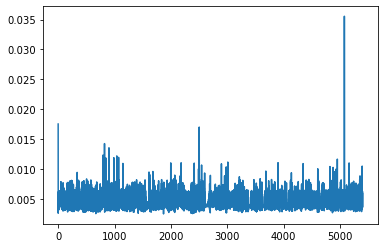

In [40]:
plt.plot(torch.Tensor(training_time).cpu())

In [41]:
def plotTrainingTime(training_time):
    plt.plot(training_time)
    plt.xlabel("Epoch")
    plt.ylabel("Training Time (s)")

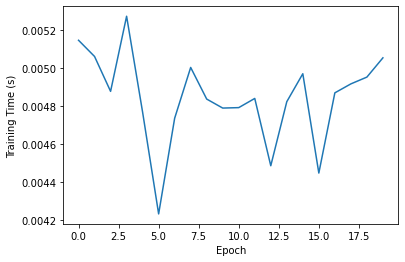

In [42]:
plotTrainingTime(training_time_per_epoch)

In [43]:
saveObject = {
    'train_losses': train_losses,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch,
    'train_accs': train_accs,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch,
    'training_time': training_time,
    'training_time_per_epoch': training_time_per_epoch,
    'val_losses': val_losses,
    'val_accs': val_accs
}

torch.save(saveObject, 'baseModeltrainingHist.pt')

## Plot from saved file

In [44]:
loadObject1 = torch.load('baseModeltrainingHist.pt')

## Potting loss

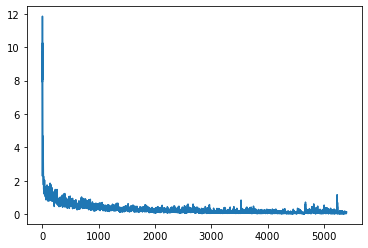

In [45]:
plt.plot(torch.Tensor(loadObject1['train_losses']).cpu())

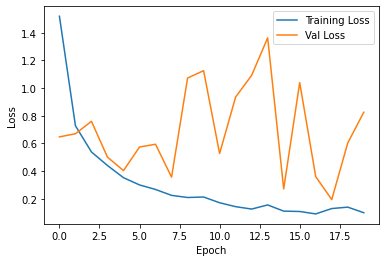

In [46]:
plotLoss(torch.Tensor(loadObject1['avg_train_losses_per_epoch']).cpu(), torch.Tensor(loadObject1['val_losses']).cpu())

## Plotting accuracy

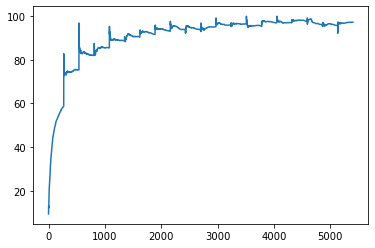

In [47]:
plt.plot(torch.Tensor(loadObject1['train_accs']).cpu())

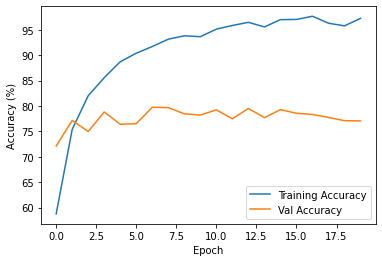

In [48]:
plotAccuracy(torch.Tensor(loadObject1['avg_train_accs_per_epoch']).cpu(), torch.Tensor(loadObject1['val_accs']).cpu())

## Plotting training time

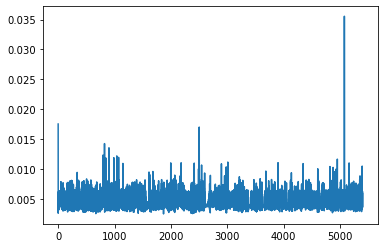

In [49]:
plt.plot(torch.Tensor(loadObject1['training_time']).cpu())

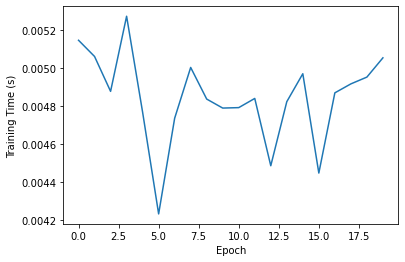

In [50]:
plotTrainingTime(loadObject1['training_time_per_epoch'])

# Train Model 2

In [51]:
model2 = deepEuroCNN().to(device)

In [52]:
print(model2)

deepEuroCNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=50176, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [53]:
count_parameters(model2)

  3456
   128
   128
   128
294912
   256
   256
   256
5017600
   100
  5000
    50
   500
    10
______
5322780


## Test Model

In [54]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = model2(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [55]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

## Train Model

In [56]:
filepath2 = 'bestModel2Para.pt'

In [57]:
train_losses2, avg_train_losses_per_epoch2, train_accs2, avg_train_accs_per_epoch2, training_time2, training_time_per_epoch2, val_losses2, val_accs2 = train(model2, optimizer, J_fn, filepath2, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.90 - Train Acc: 42.38 - Total Time: 0.02s
Epoch: 1 - Batch: 128 - Train Loss: 1.11 - Train Acc: 49.21 - Total Time: 0.01s
Epoch: 1 - Batch: 192 - Train Loss: 1.28 - Train Acc: 53.69 - Total Time: 0.01s
Epoch: 1 - Batch: 256 - Train Loss: 1.08 - Train Acc: 56.89 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.33 - Avg Train Acc: 57.59 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.85 - Val Acc: 71.32
Epoch: 2 - Batch: 64 - Train Loss: 1.07 - Train Acc: 72.19 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 1.30 - Train Acc: 71.56 - Total Time: 0.01s
Epoch: 2 - Batch: 192 - Train Loss: 0.77 - Train Acc: 72.69 - Total Time: 0.01s
Epoch: 2 - Batch: 256 - Train Loss: 0.77 - Train Acc: 73.48 - Total Time: 0.01s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.79 - Avg Train Acc: 73.51 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.73 - Val Acc: 75.21
Epoch: 3 - Batch: 64 - Train Loss: 0.77 - Train Acc: 76.93 - T

## Plotting loss

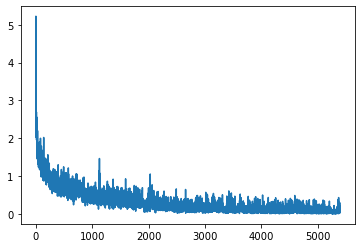

In [58]:
plt.plot(torch.Tensor(train_losses2).cpu())

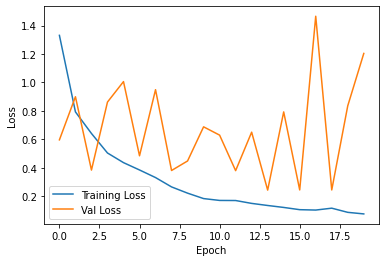

In [59]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch2).cpu(), torch.Tensor(val_losses2).cpu())

## Plotting accuracy

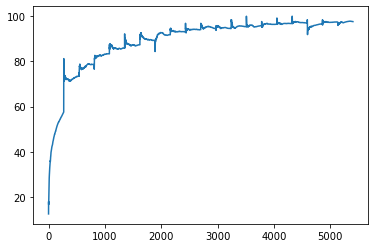

In [60]:
plt.plot(torch.Tensor(train_accs2).cpu())

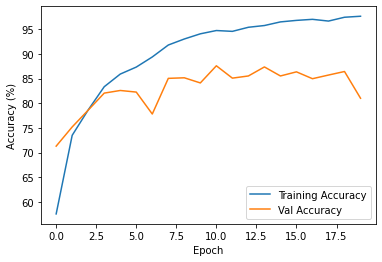

In [61]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch2).cpu(), torch.Tensor(val_accs2).cpu())

## Plotting training time

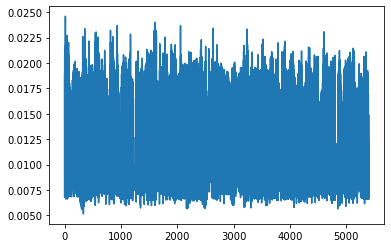

In [62]:
plt.plot(torch.Tensor(training_time2).cpu())

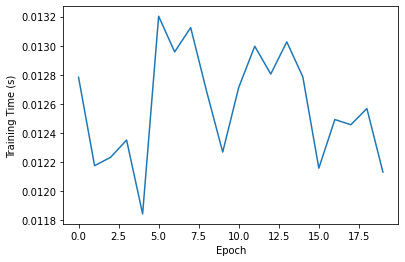

In [63]:
plotTrainingTime(training_time_per_epoch2)

In [64]:
saveObject = {
    'train_losses': train_losses2,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch2,
    'train_accs': train_accs2,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch2,
    'training_time': training_time2,
    'training_time_per_epoch': training_time_per_epoch2,
    'val_losses': val_losses2,
    'val_accs': val_accs2
}

torch.save(saveObject, 'Model2TrainingHist')

# Train Model 3

In [65]:
model3 = deeperEuroCNN().to(device)

In [66]:
print(model3)

deeperEuroCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=9216, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)


## Model Parameters

In [67]:
count_parameters(model3)

  1728
    64
    64
    64
 73728
   128
   128
   128
294912
   256
   256
   256
1843200
   200
 20000
   100
  7500
    75
   750
    10
______
2243547


## Test Model

In [68]:
random_image = torch.rand((50, 3, 64, 64)).to(device)
out = model3(random_image)
print(out.shape)

torch.Size([50, 10])


## Loss function and optimizer

In [69]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

## Train Model

In [70]:
filepath3 = 'bestModel3Para.pt'

In [71]:
train_losses3, avg_train_losses_per_epoch3, train_accs3, avg_train_accs_per_epoch3, training_time3, training_time_per_epoch3, val_losses3, val_accs3 = train(model3, optimizer, J_fn, filepath3, 20)

Epoch: 1 - Batch: 64 - Train Loss: 1.23 - Train Acc: 46.61 - Total Time: 0.01s
Epoch: 1 - Batch: 128 - Train Loss: 1.55 - Train Acc: 54.26 - Total Time: 0.01s
Epoch: 1 - Batch: 192 - Train Loss: 0.61 - Train Acc: 58.67 - Total Time: 0.01s
Epoch: 1 - Batch: 256 - Train Loss: 0.71 - Train Acc: 61.80 - Total Time: 0.01s
++++++End of Epoch 1 ++++++ Avg Train Loss: 1.07 - Avg Train Acc: 62.33 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.79 - Val Acc: 73.06
Epoch: 2 - Batch: 64 - Train Loss: 0.60 - Train Acc: 75.44 - Total Time: 0.01s
Epoch: 2 - Batch: 128 - Train Loss: 0.64 - Train Acc: 75.61 - Total Time: 0.01s
Epoch: 2 - Batch: 192 - Train Loss: 0.30 - Train Acc: 76.40 - Total Time: 0.01s
Epoch: 2 - Batch: 256 - Train Loss: 0.58 - Train Acc: 76.86 - Total Time: 0.01s
++++++End of Epoch 2 ++++++ Avg Train Loss: 0.69 - Avg Train Acc: 76.96 - Avg Train Time: 0.01
++++++Validation++++++ Val Loss: 0.64 - Val Acc: 78.75
Epoch: 3 - Batch: 64 - Train Loss: 0.56 - Train Acc: 79.98 - T

## Plotting loss

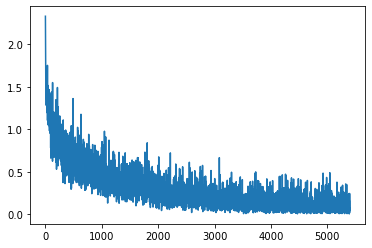

In [72]:
plt.plot(torch.Tensor(train_losses3).cpu())

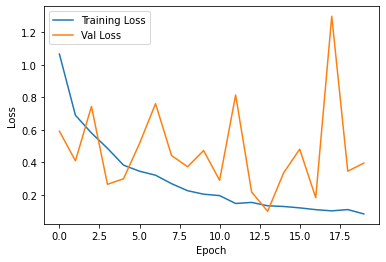

In [73]:
plotLoss(torch.Tensor(avg_train_losses_per_epoch3).cpu(), torch.Tensor(val_losses3).cpu())

## Plotting accuracy

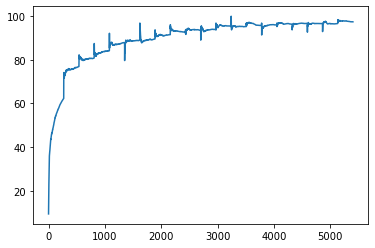

In [74]:
plt.plot(torch.Tensor(train_accs3).cpu())

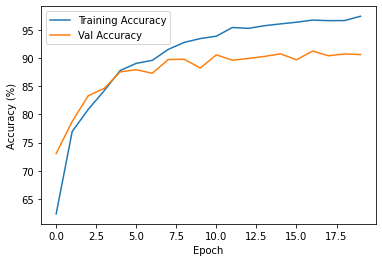

In [75]:
plotAccuracy(torch.Tensor(avg_train_accs_per_epoch3).cpu(), torch.Tensor(val_accs3).cpu())

## Plotting training time

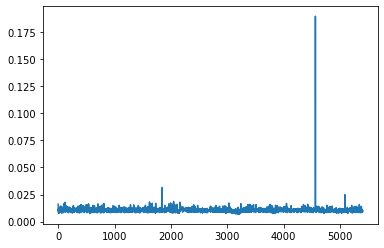

In [76]:
plt.plot(torch.Tensor(training_time3).cpu())

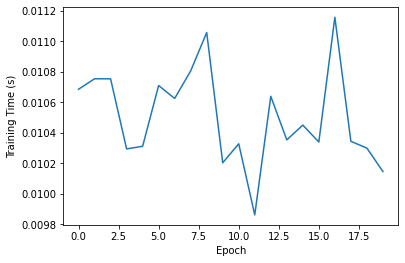

In [77]:
plotTrainingTime(training_time_per_epoch3)

In [78]:
saveObject = {
    'train_losses': train_losses3,
    'avg_train_losses_per_epoch': avg_train_losses_per_epoch3,
    'train_accs': train_accs3,
    'avg_train_accs_per_epoch': avg_train_accs_per_epoch3,
    'training_time': training_time3,
    'training_time_per_epoch': training_time_per_epoch3,
    'val_losses': val_losses3,
    'val_accs': val_accs3
}

torch.save(saveObject, 'Model3TrainingHist')

## Comparison of Three Models

## Training Loss plot

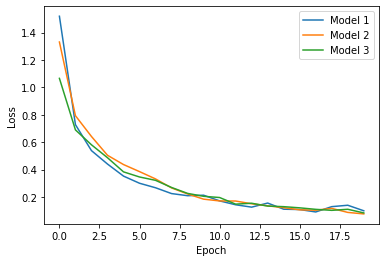

In [79]:
plt.plot(torch.Tensor(avg_train_losses_per_epoch).cpu())
plt.plot(torch.Tensor(avg_train_losses_per_epoch2).cpu())
plt.plot(torch.Tensor(avg_train_losses_per_epoch3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Validation Loss Plot

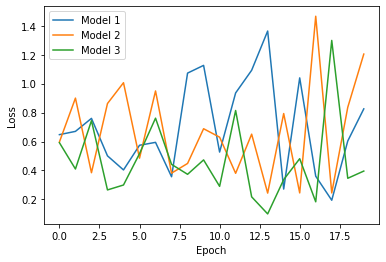

In [80]:
plt.plot(torch.Tensor(val_losses).cpu())
plt.plot(torch.Tensor(val_losses2).cpu())
plt.plot(torch.Tensor(val_losses3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Accuracy Plot (Training data)

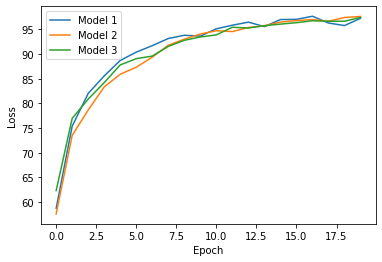

In [81]:
plt.plot(torch.Tensor(avg_train_accs_per_epoch).cpu())
plt.plot(torch.Tensor(avg_train_accs_per_epoch2).cpu())
plt.plot(torch.Tensor(avg_train_accs_per_epoch3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

## Accuracy Plot (Validation data)

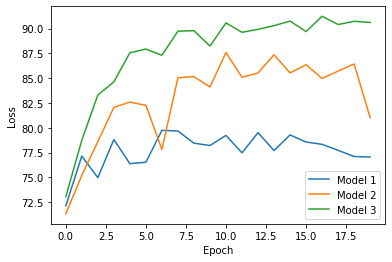

In [82]:
plt.plot(torch.Tensor(val_accs).cpu())
plt.plot(torch.Tensor(val_accs2).cpu())
plt.plot(torch.Tensor(val_accs3).cpu())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Model 1", "Model 2", "Model 3"])

# 5. Test

In [83]:
checkpoint1 = torch.load(filepath)
checkpoint2 = torch.load(filepath2)
checkpoint3 = torch.load(filepath3)

In [84]:
bestModel1 = EuroCNN().to(device)
bestModel2 = deepEuroCNN().to(device)
bestModel3 = deeperEuroCNN().to(device)

In [85]:
bestModel1.load_state_dict(checkpoint1['model_state_dict'])
bestModel2.load_state_dict(checkpoint2['model_state_dict'])
bestModel3.load_state_dict(checkpoint3['model_state_dict'])

<All keys matched successfully>

In [86]:
bestModel1.eval()
bestModel2.eval()
bestModel3.eval()

deeperEuroCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (batchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=9216, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=10, bias=True)
  (relu): ReLU()
  (dropoutLayer): Dropout(p=0.2, inplace=False)
)

In [87]:
def testModel(model):
    with torch.no_grad():
        correct = 0
        acc     = 0
        total   = 0
        allPrediction       = []
        correctLabels       = []
        misclassifiedLabels = []
        
        for images, targets in test_loader:
            images  = images.to(device)
            targets = targets.to(device)                  

            yhat    = model(images)
            predicted = torch.max(yhat, 1)[1] 
            batch_corr = (predicted == targets).sum()
            correct   += batch_corr
            total     += targets.shape[0]
            
            for i in range(len(predicted)):
                if predicted[i] != targets[i]:
                    misclassifiedLabels.append({
                        'correctLabel': targets[i],
                        'predicted': predicted[i],
                        'image': images[i]
                    })

            allPrediction.append(predicted)
            correctLabels.append(targets)

        acc = 100 * correct / total
        print(f"Accuracy: {acc:.2f}")
        
        return allPrediction, correctLabels, misclassifiedLabels

## Accuracy of Model 1

In [88]:
allPrediction1, correctLabels1, misclassifiedLabels1 = testModel(bestModel1)

Accuracy: 78.19


## Accuracy of Model 2

In [89]:
allPrediction2, correctLabels2, misclassifiedLabels2 = testModel(bestModel2)

Accuracy: 88.59


## Accuracy of Model 3

In [90]:
allPrediction3, correctLabels3, misclassifiedLabels3 = testModel(bestModel3)

Accuracy: 91.59


## Due to confidential issue other extensive analysis is not upoaded